In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle5 as pkl

from sklearn.utils.class_weight import compute_class_weight
from sklearn.linear_model import SGDClassifier

from model_fns import embed, get_preds, print_stats
from plotting import get_plots, plot_multiclass_roc, get_gt

wsize=30

# **Instructions**

This document is a template, and you are not required to follow it exactly. However, the kinds of questions we ask here are the kinds of questions we want you to focus on. While you might have answered similar questions to these in your project presentations, we want you to go into a lot more detail in this write-up; you can refer to the Lab homeworks for ideas on how to present your data or results. 

You don't have to answer every question in this template, but you should answer roughly this many questions. Your answers to such questions should be paragraph-length, not just a bullet point. You likely still have questions of your own -- that's okay! We want you to convey what you've learned, how you've learned it, and demonstrate that the content from the course has influenced how you've thought about this project.

# Online Learning for Patient Breathing Time Series
Project mentor: Numair Sani

Bijan Varjavand <bvarjav1@jhu.edu>, Hui-Yun Lin <hlin71@jhu.edu>, Dante Basile <dbasile1@jhu.edu>

https://github.com/bvarjavand/CS-475-675-Breathing

# Outline and Deliverables

List the deliverables from your project proposal. For each uncompleted deliverable, please include a sentence or two on why you weren't able to complete it (e.g. "decided to use an existing implementation instead" or "ran out of time"). For each completed deliverable, indicate which section of this notebook covers what you did.

If you spent substantial time on any aspects that weren't deliverables in your proposal, please list those under "Additional Work" and indicate where in the notebook you discuss them.

### Uncompleted Deliverables
1. "Expect to Accomplish #1": Implement an LSTM for multi-class classification. (+ hyperparameter tuning). Most of the challenges were due to the class imbalance and not the complexity of the data. We instead trained an online linear SVM.
2. "Expect to Accomplish #2": Compare performance between Logistic regression and LSTM model. We used a simpler model due to the reasons stated above. We were still able to compare performance between logistic regression and a linear SVM.
3. "Would like to Accomplish #1": Implement live demo onto the HoloLens. We ran out of time, there was so much to do to just get simple models working.
4. "Would like to Accomplish #2": Provide the model and HoloLens code to JHH to allow them to run trials with patients. Same reason as 3. Hopefully our live demo is close to integration with a hololens.
5. "Would like to Accomplish #3": Train other modern models for this task such as self-attention transformers. Same reason as 3. The more complex models are difficult to implement in an online setting.


### Completed Deliverables
1. "Must Complete #1": Anonymize and clean the entire data.  [clean_preprocess.py](https://github.com/bvarjavand/CS-475-675-Breathing/blob/master/clean_preprocess.py)
2. "Must Complete #2": Preprocessing to create labels. [clean_preprocess.py](https://github.com/bvarjavand/CS-475-675-Breathing/blob/master/clean_preprocess.py) 
3. "Must Complete #3": Run a logistic regression classifier on autoregressive features on the data to serve as a baseline. Modified to use naive baseline. (cells 6,7,8)
4. "Expect to Accomplish #3": Create live demo demonstrating the model running in an online setting to imitate what a patient might see [demo.py](https://github.com/bvarjavand/CS-475-675-Breathing/blob/master/demo.py) (you can see the demo run at the end of our team's presentation in the recording).
 


### Additional Deliverables
1. We decided to add features to the sliding window model. (cells 2, 3)
2. We decided to add a weighted loss function by class. (cell 5)
3. We decided to add a downsampling step in our data preparation for training. (cells 3,4)

# Preliminaries

## What problem were you trying to solve or understand?

**What are the real-world implications of this data and task?**

Our ultimate goal is to help to improve radiotherapy through improving consistency of patient’s respiratory motion via providing more guidance during ABC(Active Breathing Coordinator) training.

During radiotherapy for pancreatic cancer patients, tumor position could vary severely due to the respiratory motion. To hold the tumor position still, patients need to perform deep inspiration breath hold(DIBH) during the therapy. By performing DIBH, the beam of radiation could deliver when patients hold their breath and try to immobolize tumor’s motion. ABC is a medical device that could help monitor patients’ breathing signal and show them their real time respirotory air volume as well as  respective threshold that they need to reach when holding their breath. But the average variation of tumor position is still 5mm according to 53 pancreatic cancer patients’ data from Johns Hopkins Hospital. However, the margin for radiotherapy is 2mm. So we want to help train patients to perform consistent breathing patterns throughout their treatments. By doing so, we first need to recognize different breathing patterns and classify them into different stages. After that, we could provide different guidance according to different stages. For example, if we specify stage 0 as “normal breath”, stage 1 as “deep inhalation”, stage 2 as “holding breath”, and stage 3 is “deep exhalation”, then we know we need to care more about stage 1 and 2, since those are the two stages that will mostly affect tumor’s position during DIBH. Once we specify stage 1 and 2, we can overlay guiding line or safe zone on the screen that shows breathing signal. Whereas during stage 0 and 3, we don’t need to implement guidance on it.

**How is this problem similar to others we’ve seen in lectures, breakouts, and homeworks?**

The data is composed of time series. Each sample has correlation with the previous. We have modeled such relationships with HMMs in class.

**What makes this problem unique?**

The data is structured in such a way that online learning makes sense. The breathing patterns vary along patients. Even for the same patient, he\she might breath slightly differently across days. That’s why we need online learning to adapt out model to each patient. 
Another interesting thing is that we don’t have ground truth for our data. We specify and generate our own labels. So there might exist other better ways to categorize stages. 
For our model, we expect it to do real-time predictions rather than just real-time classifications because we need future predictions to draw guideline. For example, during the transformation from stage 1 to 2, we don’t want to draw a guide line that keeps going up.

**What ethical implications does this problem have?**

We are working closely and making decisions about sensitive health information regarding people. We expect this model to help guide patients when they use ABC. If the guidance is incorrect or conflict with nurses instructions, it might cause real world outcomes. 
Also, when we’re dealing with patients’ data, we always need to consider the security of it.

## Dataset(s)

**How were they collected?**

The data was collected by Johns Hopkins Hospital's radiation oncology team from their pancreatic cancer patients. 

**Why did you choose them?**

One of our teammate, Lin, is working with the radiation oncology team this semester for another project. So she has the access to the data. She also got approval from the hospital to use this dataset once all the patients are anonymized.

**How many examples in each?**

There are 868 patients in our whole dataset, and for each patient, they have one to several .dat time series data inside. Usually, the first .dat file recorded the training session, and the rests recorded the radiotherapy treatment session. The length of each file depends on the length of that session. The timestep of the data is 0.02 second. A read-only link to all patient data (anonymized) is [here](https://drive.google.com/drive/folders/1httFspwChMRiO6WFYhjVgrKIPdhBaVLh?usp=sharing). A read-only link to all downsampled patient data is [here](https://drive.google.com/drive/folders/10FQ8wbJWK5z3u723LqRcVFA9ngV-YRUy?usp=sharing). We include patient 1 in our repo for the notebook.

### Note: For this notebook we consider only the best parameters for demonstration purposes. Runs evaluating different model/parameter combinations are [here](https://github.com/bvarjavand/CS-475-675-Breathing/blob/master/downsampled.ipynb). Methods used are imported from [fn](https://github.com/bvarjavand/CS-475-675-Breathing/blob/master/model_fns.py) and [plotting](https://github.com/bvarjavand/CS-475-675-Breathing/blob/master/plotting.py) scripts. 

In [2]:
fpaths = [f'./patients_data/patient_{i}/' for i in range(1,13)]
fpathsinit = [f'./downsampled_data/patient_{i}/' for i in range(1,13)]
X = pd.DataFrame(pkl.load(open(fpathsinit[0]+"train_X.pkl", "rb")))
y = pd.DataFrame(pkl.load(open(fpathsinit[0]+"train_y.pkl", "rb")))
datasize = None
X = X[:datasize]
y = y[:datasize]
wsize=30

print(X.head())
print(y.head())

   Time  Volume  from_thresh   diff  ID  file_num
0  0.02   0.020       -0.980  0.000   1         1
1  0.04   0.020       -0.980 -0.004   1         1
2  0.06   0.016       -0.984  0.000   1         1
3  0.08   0.016       -0.984 -0.016   1         1
4  0.10   0.000       -1.000  0.000   1         1
   Label
0      0
1      0
2      0
3      0
4      0


## Pre-processing

**What features did you use or choose not to use? Why?**

We choose to use the "time step" and "air volumn" features because these two are the only important feature we need to classify and predict the breathing stages.
We didn't use other features in the data, such as "Balloon Valve Status" and "Patient Switch" because "Patient Switch" is just an indicator whether the patient is ready to perform deep inspiration breath hold, so it's not related to our classification. "Balloon Valve Status" just shows wether the balloon valve of the ABC is indlated or deflated, which could directly derive from "air volumn". So we didn't use it.

**If you have categorical labels, were your datasets class-balanced?**

No, the original dataset is terribly imbalanced. Stage 0 outnumbered the other 3 stages. That's the reason why we tried to downsample stage 0 and use weighted loss function in our training later. 

**How did you deal with missing data? What about outliers?**

The active breating coordinationg will override the missing data point with the data from the previous time step. So there's no missing data in the file we get. We didn't deal with the outlier because it happens rarely (usually after deep exhalation because of the inertia of the turbine in the ABC) and we don't think it affects our training much. 

**What approach(es) did you use to pre-process your data? Why?**

We added other two new features "diff" and "from_thresh". "diff" comes from the air volumn of current time step subtract the air volumn of the previous time step. So this feature could represent the slope of the air volumn. We added this feature because we think the slope might effect the classification result. We also added "from_thresh" because every patient has different lung capacity, so knowing the number of the air volumn subtract their own threshold might be more useful than just knowing the air volumn.  
We also downsampled a large proportion of stage 0 datapoints to make our dataset class-balanced.

**Are your features continuous or categorical? How do you treat these features differently?**

All of our four features are continuous, so we treat them in the same way.

In [3]:
Xembed, yembed = embed(X, y['Label'], stride=1, window_size=wsize, full_feat=True)

Before preprocessing


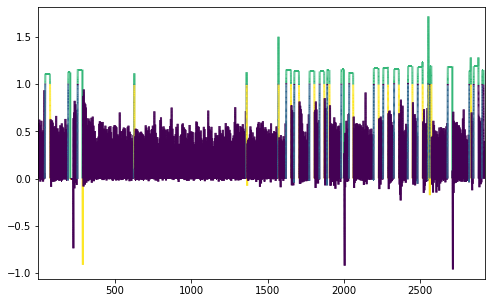

After


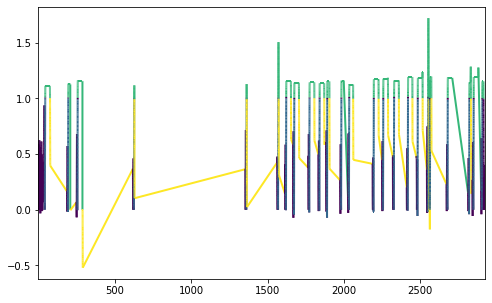

In [4]:
print("Before preprocessing")
get_gt(pd.DataFrame(pkl.load(open(fpaths[0]+"train_X.pkl", "rb"))), 
       pd.DataFrame(pkl.load(open(fpaths[0]+"train_y.pkl", "rb"))), None)
plt.show()

print("After")
get_gt(X, y, None)

# Models and Evaluation

## Experimental Setup

**How did you evaluate your methods? Why is that a reasonable evaluation metric for the task?**

For each method, we trained a model on the tranining data for patiant 1 (our "validation" patient) and then performed online learnins on the testing data for patient 1. At the end, we evaluated Accuracy, class-wise accuracy, and One-v-Rest ROC curve for each class. These evaluation metrics provide plenty of information about each method in regards to the high class imbalance of our data, our primary concerm.

**What did you use for your loss function to train your models? Did you try multiple loss functions? Why or why not?**

We used log loss or hinge loss to test a logistic regression classifier and a linear SVM classifier. We also tried using loss functions weighted by class, and even tryingn the square room of each class weight. We did this in order to see if one loss function would be better than the other given all the different parameter values we checked. Due to the class imbalance we felt it was important to evaluate weighted loss functions.

**How did you split your data into train and test sets? Why?**

We split our data into train ant test in order to mimic the environment our models would be used in. Each patient has a training session where their threshold for the operation is calibrated, and then at least one session of operation. It was natural for us to treat the training session as training data, and the operation session(s) as online testing data.

In [5]:
computed_weights = compute_class_weight(class_weight='balanced',
                                       classes=np.unique(yembed),
                                       y=yembed.flatten())
computed_weights_dict = dict.fromkeys(np.unique(yembed))
for key in computed_weights_dict:
    computed_weights_dict[key] = computed_weights[key]

print(computed_weights_dict)  # we use these in our SGD loss fn's

{0: 1.0729378531073446, 1: 3.756131329113924, 2: 0.3779153068534586, 3: 6.424560216508795}


## Baselines 

**What baselines did you compare against? Why are these reasonable?**

The most simple baseline was a model that always predicted the most likely class based on priors from the training data. We felt that this was a bit too simple and leveraged the structure of our problem to use a baseline that predicted class 2 if above a given threshold and class 0 if below a given threshold. This gives perfect accuract for class 2, and is heavily biased to class 0 otherwise. It would be easy to contextualize the performance of our models compared to this baseline, since any improvements would be a result of incorporating information about our underrepresented classes 1 and 3.

**Did you look at related work to contextualize how others methods or baselines have performed on this dataset/task? If so, how did those methods do?**

This is a relatively new and specific problem, so there really aren't any other ML-based baselines that have been performed on this dataset. Indeed, we curated this dataset from raw data ourselves. The best example for an existing baseline is the rules-based one we describe above.

In [6]:
def baseline():
    X = pd.DataFrame(pkl.load(open(fpaths[0]+f"test_X1.pkl", "rb")))
    y = pd.DataFrame(pkl.load(open(fpaths[0]+f"test_y1.pkl", "rb")))
    pred = (X.iloc[:,2]>0).astype(int)
    pred *= 2 # Classes 0 (under thresh) and 2 (above thresh)
    return X, y, pred

X_base, y_base, pred_base = baseline()

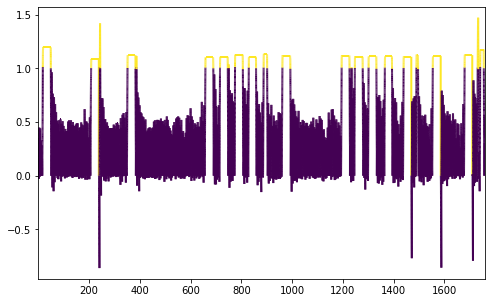

In [7]:
get_plots([X_base], [y_base], [pred_base[wsize+1:]], None, wsize)

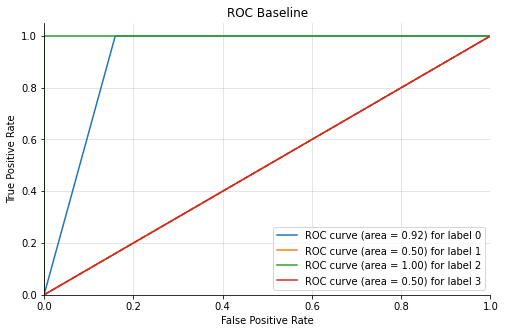

In [8]:
plot_multiclass_roc(X_base, y_base, pred_base[wsize+1:], n_classes=4, figsize=(8,5), title="Baseline", wsize=wsize)

## Methods

**What methods did you choose? Why did you choose them?**

We chose 2 simple linear models - logistic regression and linear SVM. We chose them because (1) they were straightforward and interpretable, (2) they could be used for online learning, and (3) they trained and ran quickly enough in an online setting to be used live.

**How did you train these methods, and how did you evaluate them? Why?**

We trained these methods by fitting parameters to the train session for patient 1, then evaluated them by their performance on the online test set for patient 1. Depending on their overall and class-specific accuracties as well as their class-specific ROC curves, we could easily see which combination of model and parameters performed the best.

**Which methods were easy/difficult to implement and train? Why?**

The methods were easy to implement in the sense that the models were simple, but the main difficuly lied in the ways we set up our data to be used for training. Steps like time series downsampling of a specific class were difficult to do, while training our online models on the prepered data was straightforward.

**For each method, what hyperparameters did you evaluate? How sensitive was your model's performance to different hyperparameter settings?**

For each of our models we evaluated parameters relating to sliding window width, weights on the loss function, utilization of different additional features, and whether we were downsampling our data initially or not. By far the most impactful was the size of the sliding window we used, while we could improve performance incorporating the other changes to our methods.

In [9]:
classifiers = {
    "log-weight": SGDClassifier(
        random_state=0, loss="log", class_weight=computed_weights_dict).fit(Xembed, np.squeeze(yembed)),
    "svm-weight": SGDClassifier(
        random_state=0, class_weight=computed_weights_dict).fit(Xembed, np.squeeze(yembed)),
}

In [10]:
class_data = {}
for key, clf in classifiers.items():
    print(f"Classifier {key}")
    class_data[key] = get_preds(clf, 1, fpaths, wsize)

Classifier log-weight



Classifier svm-weight


In [11]:
# Show plots of how these models performed during training.
#  For example, plot train loss and train accuracy (or other evaluation metric) on the y-axis,
#  with number of iterations or number of examples on the x-axis.

## Results

**What about these results surprised you? Why?**

The simple baseline achieved over .90 ROC AUC for class 0 and 2. However,
it achieved only .50 ROC AUC for class 1 and 3
(which were underrepresented). Therefore, we deicided that
the main challenge of this dataset was not in data complexity but in learning
effectively with respect to all classes.
The class imbalance was more difficult to overcome than expected. Weighting
the loss function improved the ROC AUC for underrepresented classes (class 1 and 3), but it
caused further drop in accuracy. We believe the cause of this was that, due
to the increased weights along with the class imbalance, the model was being
incentivised to never predict the underrepresented classes. ROC AUC
increased because the model was rarely predicting positive for the
underrepresented classes in the first place. ROC AUC only considers positive
predictions. However, the accuracy for the underrepresented classes fell because
there were many false negatives. Downsampling the dataset before training
mitigated this issue and allowed us to achieve an increased ROC AUC with less
penalty to accuracy.

**Did your models over- or under-fit? How can you tell? What did you do to address these issues?**

Our models overfitted, especially considering the class imbalance. This can
be seen in the model's general tendancy to predict the overrepresented classes
more accurately across patients. In order to address this, we applied loss
function weighting and downsampling to emphasize the underrepresented classes.

**What does the evaluation of your trained models tell you about your data? How do you expect these models might behave differently on different data?**

Most notably, the model results demonstrate the class imbalance. We were not
able to fully eliminate the effects of this. The model results also speak to
the relative simplicity of our dataset. After training on a patient's simulated
prerecorded data, a SVM was able to achieve good accuracy and ROC AUC,
especially for the common classes. This makes sense because the common classes
are also the easiest to discern. They are separated by a simple theshold.
This dataset is characterized by simple low-dimensional data in which the
challenge mainly arises from the fact that the most difficult to predict
classes also have the least occurance.

In [12]:
for model, clfdata in class_data.items():
    print(f"Model {model}")
    print_stats(clfdata[1][0][wsize+1:].values.flatten(), clfdata[2][0].flatten())

Model log-weight
MSE: 0.11359992723055407
acc: 0.9576686488760532
class 0 acc: 0.9678315717695193
class 1 acc: 0.4439400817067635
class 2 acc: 0.9958927277120078
class 3 acc: 0.7739786856127886
avg class acc (unweighted): 0.7954107667002697
Model svm-weight
MSE: 0.06896042024355024
acc: 0.9699712333284063
class 0 acc: 0.98302010640503
class 1 acc: 0.580499653018737
class 2 acc: 0.996579476861167
class 3 acc: 0.8434408602150537
avg class acc (unweighted): 0.8508850241249969


Model log-weight


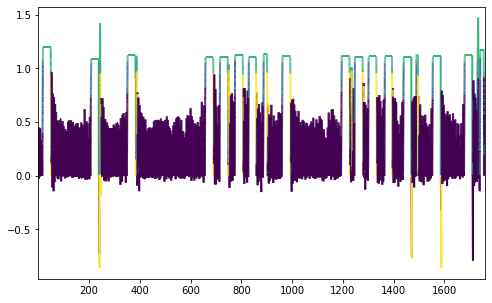

Model svm-weight


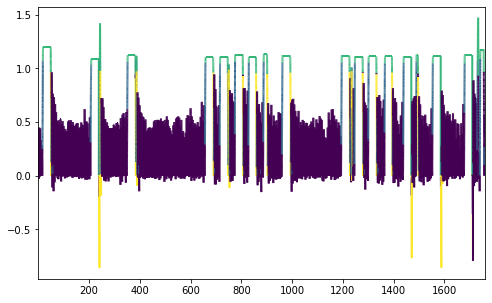

In [13]:
for model, clfdata in class_data.items():
    print(f"Model {model}")
    get_plots(*clfdata, None)

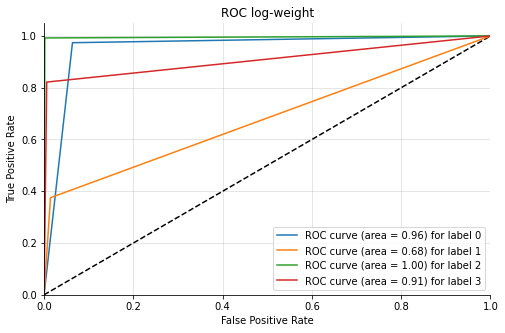

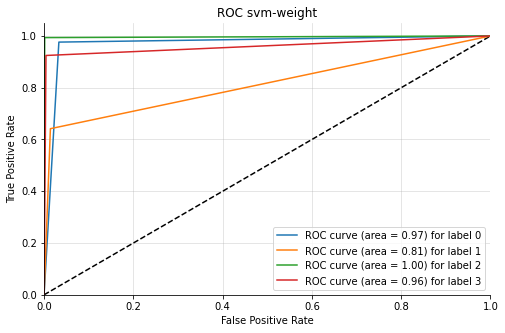

In [14]:
for model, clfdata in class_data.items():
    plot_multiclass_roc(
        clfdata[0][0], clfdata[1][0], clfdata[2][0], n_classes=4, figsize=(8,5), title=model)

Looking at AUCs, even with all our efforts we are still overfitting to the majority classes, albeit less so.

# Discussion

## What you've learned

**What concepts from lecture/breakout were most relevant to your project? How so?**

Lecture topics relating to SVMs, Logistic Regression, and other non-deep
machine learning algorithms were relevant. Knowing that a simple
model can function relatively well without hyperparameter tuning on our data
helped us understand the relative simplicity of our data and influenced our
decision to not invest in implementing a more complex model. Topics relating to
accountability and transparent presentation of results were relevant. Due to the class imbalance, accuracy alone was not a valid assessment of model effectiveness. Breaking accuracy up by class and ROC AUC curves helped address this. Online learning and practical ML were relevant. Our model is expected
to train on existing data and then make predicions in real time for each patient in a clinical setting. We took this into account by modifying our training procedure to mimic this environment.

**What aspects of your project did you find most surprising?**

The difficulty of overcoming the class imbalance was surprising. The simplicity of our data and the fact that SVMs were able to perform well disregarding the class imbalance was surprising.

**What lessons did you take from this project that you want to remember for the next ML project you work on? Do you think those lessons would transfer to other datasets and/or models? Why or why not?**

The most important lesson was the difficulty with overcoming class imbalance. This represented the brunt of model design work and was not completely accounted for. Many real world clinical datasets have significant class imbalance. For example, many diseases, especially rare ones, have a class imbalance with respect to healthy individuals. A diagnosis classifier would have to take this into account. Furthermore, as healthcare models interact with people, they are exposed to any biases represented in the societies they serve. These could include underrepresented or marginalized groups with respect to healthcare resource allocation. It is important that modles do not reinforce these trends.

**What was the most helpful feedback you received during your presentation? Why?**

The most helpful topic we will focus on according to our feedbacks is thorough investigation of how to best integrate our work into the clinic. One group brought up the possibility that different definitions of the breathing stages could be used at different clinics. This would be important to take into account when trying to achieve widespread adoption and comparing our model's results to various clinical data. Other groups called attention to the ehthics questions of a model that affects patient treatment. When moving towards the clinical integration step, it would be important to consult with medical experts in order to better understand the implications of deploying a system like this in the clinic. Clear testing would be done, and the explainability of the model might need to be increased.

**If you had two more weeks to work on this project, what would you do next? Why?**

Given more time to work on this problem, it might be beneficial to explore different model architectures. LSTM models perform well in an online setting and are well suited to time-series data. Howerver, we found that this dataset was reasonably understandable by simple SVM modles. The main issue was class imbalance. Decision trees have been found to handle class imbalance well [Cieslak D.A., Chawla N.V. (2008) Learning Decision Trees for Unbalanced Data. In: Daelemans W., Goethals B., Morik K. (eds) Machine Learning and Knowledge Discovery in Databases. ECML PKDD 2008. Lecture Notes in Computer Science, vol 5211. Springer, Berlin, Heidelberg. https://doi.org/10.1007/978-3-540-87479-9_34](https://link.springer.com/chapter/10.1007/978-3-540-87479-9_34). Furthermore, Mondrian Forests [Mondrian Forests: Efficient Online Random Forests Balaji Lakshminarayanan, Daniel M. Roy, Yee Whye Teh Advances in Neural Information Processing Systems (NIPS), 2014.](http://www.gatsby.ucl.ac.uk/~balaji/mondrian_forests_nips14.pdf) have successfully adapted decision tree algorithms to the online setting. Implementation of Mondrian Forests might be a better use of increasing model complexity, as previous attempts at data processing and hyperparameter tuning have room for improvement with respect to the class imbalance.